In [2]:
# import related to mlflow and dagshub
import mlflow
import mlflow_exp as mle
import dagshub
from mlflow import MlflowClient

# import preprocessing file
from steps import data_ingestion as di
from steps import data_transformation as dt
from steps import model_training as mt

import os

In [74]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#DAGSHUB_TOKEN = dagshub.auth.get_token()


In [4]:
# connection config to dagshub

MLFLOW_TRACKING_URI='https://dagshub.com/Syamil-Ali/E2E_Loan_Application.mlflow'
MLFLOW_TRACKING_USERNAME='Syamil-Ali'
MLFLOW_TRACKING_PASSWORD='2e6b27e2093c83eacbf6777913b6d087592d1710'

In [6]:
# put them into os.environment

# It's recommended to define this within the code, because it's project specific (but this works too)
os.environ['MLFLOW_TRACKING_URI']=MLFLOW_TRACKING_URI

# Recommended to define as environment variables
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD

In [10]:
# create a client to access the MLflow tracking server
client = mlflow.MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [12]:
# read file

file_path = '../data/Loan_Data.csv'
df = di.data_ingest(file_path)

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
# investigate a bit

In [14]:
def table_info(df):
    
    def classified(x):
        if x == 'int64':
            return 'int'
        elif x == 'object':
            return 'str'
        else:
            return 'float'
        
    df_col = df.columns # get column name
    new_df = df.dtypes # get datatype
    total_row = df.shape[0] # get total row
    new_df.index.name = 'Columns'
    
    new_df = new_df.to_frame(name='Pandas_dtype') # create new dataframe from the pandas.dtype dataframe
    new_df['Python_type'] = new_df['Pandas_dtype'].apply(classified) # add python type
    new_df["Total_Unique"] = df.nunique()
    new_df['Missing_Value'] = df.isnull().sum()  # add missing value col
    new_df['% Missing_Values'] = round((new_df['Missing_Value'] / total_row) * 100,2) # add % missing val
    
    
    print('------------ DATA SUMMARY ----------')
    print(f'\nTotal Rows   : {total_row}')
    print(f'Total Columns: {df.shape[1]}')
    
    val = df.duplicated().value_counts()
    print(f'\nTotal Duplicates: {len(df) - val[0]} \n')
    print('------------------------------------')
    print()
        
    
    return new_df

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [15]:
# details for the dataset = https://www.kaggle.com/datasets/devzohaib/eligibility-prediction-for-loan

# missing 

# 1. gender
# 2. married
# 3. dependents
# 4. self-employed
# 5. loan amount
# 6. loan_amount_term
# 7. credit history


table_info(df)


------------ DATA SUMMARY ----------

Total Rows   : 614
Total Columns: 13

Total Duplicates: 0 

------------------------------------



,Pandas_dtype,Python_type,Total_Unique,Missing_Value,% Missing_Values
Columns,,,,,
Loan_ID,object,str,614,0,0.00
Gender,object,str,2,13,2.12
Married,object,str,2,3,0.49
Dependents,object,str,4,15,2.44
Education,object,str,2,0,0.00
Self_Employed,object,str,2,32,5.21
ApplicantIncome,int64,int,505,0,0.00
CoapplicantIncome,float64,float,287,0,0.00
LoanAmount,float64,float,203,22,3.58


In [ ]:
# Mission to predict loan status for the application

In [25]:
# Data Understanding

# 1. What is the proportion of the applicant loan status in the dataset?

loan_status = df['Loan_Status'].value_counts()
loan_status


# looks like there are more like application that has their loan accept than not pass

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [26]:
# 2. So, whats the difference that made this?

# - get the cat and num col
cat_columns = [column for column in df.columns if df[column].dtype == 'object']
num_columns = [column for column in df.columns if df[column].dtype != 'object']

In [36]:
cat_columns.remove('Loan_Status')
cat_columns.remove('Loan_ID')

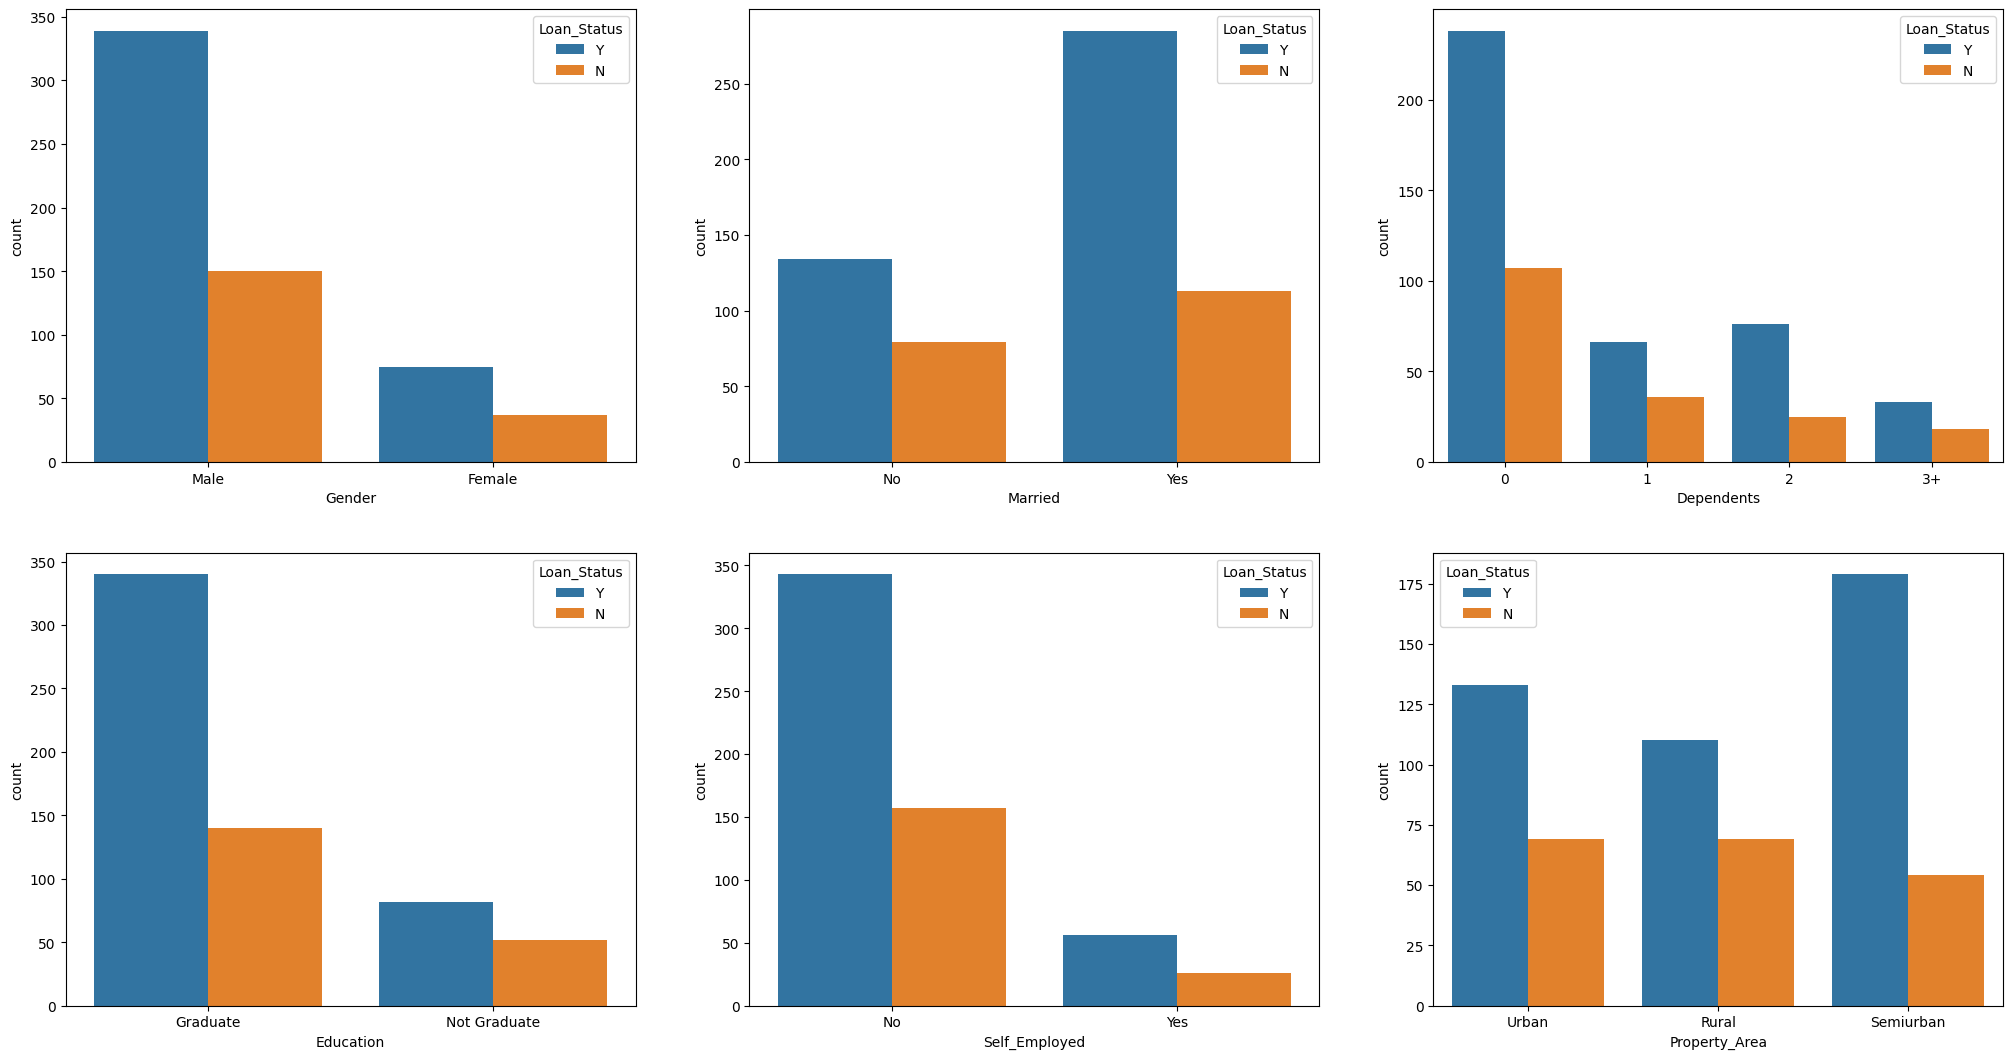

In [39]:
plt.figure(figsize = (25,20))
for i in enumerate(cat_columns):
    plt.subplot(3,3, i[0] + 1)
    sns.countplot(x= i[1], data  = df, hue='Loan_Status')

In [ ]:
# a few patter

# 1. all kind of applicants has a better chance to get their loan application approved than rejected
# 2. however, variable that shows a higher chance than the rest are:
# -> if the person is married, has low to zero dependants, graduate, and live in a semiurban area

In [45]:
# cleanup

In [46]:
# 1. drop id column

df.drop(columns = 'Loan_ID', inplace=True)

In [47]:
table_info(df)

------------ DATA SUMMARY ----------

Total Rows   : 614
Total Columns: 12

Total Duplicates: 0 

------------------------------------



,Pandas_dtype,Python_type,Total_Unique,Missing_Value,% Missing_Values
Columns,,,,,
Gender,object,str,2,13,2.12
Married,object,str,2,3,0.49
Dependents,object,str,4,15,2.44
Education,object,str,2,0,0.00
Self_Employed,object,str,2,32,5.21
ApplicantIncome,int64,int,505,0,0.00
CoapplicantIncome,float64,float,287,0,0.00
LoanAmount,float64,float,203,22,3.58
Loan_Amount_Term,float64,float,10,14,2.28


In [48]:
# 2. fill in the missing column

# column missing
# -> gender - c
# -> married - c
# -> dependents - c
# -> self_employed - c
# -> loan_amount - n
# -> loan_amount_term - n
# -> credit_history - n

In [59]:
# cleaning up the 

Columns,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
608,Male,Yes,0,Graduate,No,3232,1950.0,108.0,360.0,1.0,Rural,Y
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [ ]:
df[df['Loan_Amount_Term'] == 36]

In [55]:
df['Loan_Amount_Term'].value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

30.0

In [62]:
class fill_missing_values:
    
    def __init__(self, df):
        self.df = df
        
    
    def missing_mode(self, column):
        return self.df[column].mode()

    def missing_median(self, column):
        return self.df[column].median()
    
    def missing_mean(self, column):
        return self.df[column].mean()
        
        
df_fill_holder = fill_missing_values(df)

In [64]:
df_fill_holder.missing_mode('Gender')[0]

'Male'

In [72]:
# clean up

# for categorical cat -> use the mode (include also loan amount terms)
# for num -> use the avg func


# 2. fill in the missing column

# column missing
# -> gender - c
df['Gender'] = df['Gender'].fillna(df_fill_holder.missing_mode('Gender')[0])

# -> married - c
df['Married'] = df['Married'].fillna(df_fill_holder.missing_mode('Married')[0])

# -> dependents - c
df['Dependents'] = df['Dependents'].fillna(df_fill_holder.missing_mode('Dependents')[0])

# -> self_employed - c
df['Self_Employed'] = df['Self_Employed'].fillna(df_fill_holder.missing_mode('Self_Employed')[0])

# -> loan_amount - n
df['LoanAmount'] = df['LoanAmount'].fillna(df_fill_holder.missing_mean('LoanAmount'))

# -> loan_amount_term - n
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df_fill_holder.missing_mean('Loan_Amount_Term'))


# -> credit_history - n
df['Credit_History'] = df['Credit_History'].fillna(df_fill_holder.missing_mode('Credit_History')[0])


In [67]:
df_fill_holder.missing_mode('LoanAmount')[0]

120.0

In [73]:
table_info(df)

------------ DATA SUMMARY ----------

Total Rows   : 614
Total Columns: 12

Total Duplicates: 0 

------------------------------------



,Pandas_dtype,Python_type,Total_Unique,Missing_Value,% Missing_Values
Columns,,,,,
Gender,object,str,2,0,0.0
Married,object,str,2,0,0.0
Dependents,object,str,4,0,0.0
Education,object,str,2,0,0.0
Self_Employed,object,str,2,0,0.0
ApplicantIncome,int64,int,505,0,0.0
CoapplicantIncome,float64,float,287,0,0.0
LoanAmount,float64,float,203,0,0.0
Loan_Amount_Term,float64,float,11,0,0.0


In [ ]:
# applying ordinal encoder


from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split


In [75]:
X = df.drop(columns = 'Loan_Status').copy()
y = df['Loan_Status'].copy()
        
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                    random_state=42,  
                                    test_size=0.1,
                                    shuffle=True)

In [76]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(X_train[cat_columns])

X_train[cat_columns] = encoder.transform(X_train[cat_columns])    
X_test[cat_columns] = encoder.transform(X_test[cat_columns])

In [77]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [78]:
# testing for ml model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [79]:
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [82]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           N       0.88      0.33      0.48        21
           Y       0.74      0.98      0.84        41

    accuracy                           0.76        62
   macro avg       0.81      0.65      0.66        62
weighted avg       0.79      0.76      0.72        62

